In [381]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

import streamlit as st

import warnings
warnings.filterwarnings('ignore')

import unittest

In [382]:
def load_and_clean_data(filepath):
    """
    Load the CSV data and clean it by dropping unnecessary columns and renaming columns for clarity.
    
    Args:
    filepath (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    
    df = pd.read_csv(filepath)
    
    df = df.rename(columns={
        'Poverty rate': 'PovertyRate',
        'Unemployment rate': 'UnemploymentRate',
        'Percentage of pupils who achieved grade 9-4': 'PupilsGrade9To4',
        'crime rates': 'CrimeRates',
        'average property price 2024 Feb': 'AvgPropertyPriceFeb2024',
        'Fair pay (London Living Wage) ': 'LondonLivingWage',
        'Healthy Life Expentency': 'HealthyLifeExpectancy',
        'Green Space': 'GreenSpace',
        'Air Quality': 'AirQuality',
        'Carbon Emission': 'CarbonEmission',
        'Energy Efficiency': 'EnergyEfficiency',
        'Waste reduction': 'WasteReduction',
        'Being Ready for School': 'SchoolReadiness',
        'Good Qualification 16+': 'Qualification16Plus'
    })
    
    return df

In [383]:
def generate_user_preference(dataframe):
    
    """
    Generate random user preferences based on the range of numeric columns in the DataFrame for a single user.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    np.ndarray: An array of random user preferences.
    """
    
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    min_values = dataframe[numeric_columns].min()
    max_values = dataframe[numeric_columns].max()
    user_preference = np.random.rand(1, len(numeric_columns)) * (max_values - min_values).values + min_values.values
    
    print(f"User Preferences: {np.round(user_preference, 2)}")
    
    return user_preference

In [384]:
def impute_missing_data(dataframe):
  
    """
    Impute missing data in the DataFrame using KNNImputer.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame with missing values.

    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    
    imputer = KNNImputer(n_neighbors=3)
    numeric_df = dataframe.drop(['Area'], axis=1)
    
    imputed_df = imputer.fit_transform(numeric_df)
    
    imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns)
    
    return imputed_df

In [385]:
def visualize_data(dataframe):
  
    """
    Visualize data distributions and correlations using seaborn and matplotlib.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to visualize.
    """

    plt.figure(figsize=(16, 6))
    
    heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    
    plt.show()

In [386]:
def standardize_and_reduce_data(dataframe):
  
    """
    Standardize the data and perform PCA for dimensionality reduction.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to standardize and reduce.

    Returns:
    tuple: Scaler, PCA model, and the transformed DataFrame.
    """
    
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    pca = PCA(n_components=2)
    pca_df = pca.fit_transform(scaled_df)
    
    return scaler, pca, pca_df

In [387]:
def perform_clustering(data, num_clusters=6):
  
    """
    Perform K-Means clustering on the data.
    
    Args:
    data (np.ndarray): The input data for clustering.
    num_clusters (int): The number of clusters for K-Means.

    Returns:
    tuple: KMeans model and cluster labels.
    """
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    clusters = kmeans.fit_predict(data)
    
    return kmeans, clusters

In [388]:
def ranked_borough(dataframe, clusters, user_preference, scaler, pca, kmeans):
    """
    Recommend boroughs based on a single user's preferences and clustered data.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame.
    clusters (np.ndarray): Cluster labels for the data.
    user_preference (np.ndarray): Single user preferences to match with clusters.
    scaler (StandardScaler): The scaler used for data standardization.
    pca (PCA): The PCA model used for dimensionality reduction.
    kmeans (KMeans): The KMeans model used for clustering.

    Returns:
    list: Recommended boroughs for the nearest user cluster.
    """
    
    user_preference_scaled = scaler.transform(user_preference)
    user_pca_preference = pca.transform(user_preference_scaled)
    centroids = kmeans.cluster_centers_
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(centroids)
    distances, nearest_cluster_indices = nn.kneighbors(user_pca_preference)
    nearest_cluster = nearest_cluster_indices.flatten()[0]
    print("Nearest Cluster for User Preference:", nearest_cluster)
    
    dataframe['Cluster'] = clusters
    nearest_cluster_boroughs = dataframe[dataframe['Cluster'] == nearest_cluster]
    
    # Calculate distances between user preferences and boroughs in the nearest cluster
    cluster_data = nearest_cluster_boroughs.drop(['Area', 'Cluster'], axis=1)
    cluster_data_scaled = scaler.transform(cluster_data)
    cluster_data_pca = pca.transform(cluster_data_scaled)
    distances = cdist(user_pca_preference, cluster_data_pca, 'euclidean').flatten()
    
    nearest_cluster_boroughs['Distance'] = distances
    ranked_boroughs = nearest_cluster_boroughs.sort_values(by='Distance')
    ranked_boroughs = ranked_boroughs[['Area', 'Distance']]
    
    print("Ranked Boroughs based on User Preference:")
    print(ranked_boroughs)
    return ranked_boroughs

User Preferences: [[4.2510000e+01 4.8900000e+00 7.7650000e+01 7.7700000e+01 3.5997881e+05
  7.7750000e+01 5.9360000e+01 2.3000000e-01 2.5000000e-01 9.7100000e+00
  4.6000000e-01 3.3000000e-01 5.6220000e+01 3.0500000e+00 8.6600000e+01]]


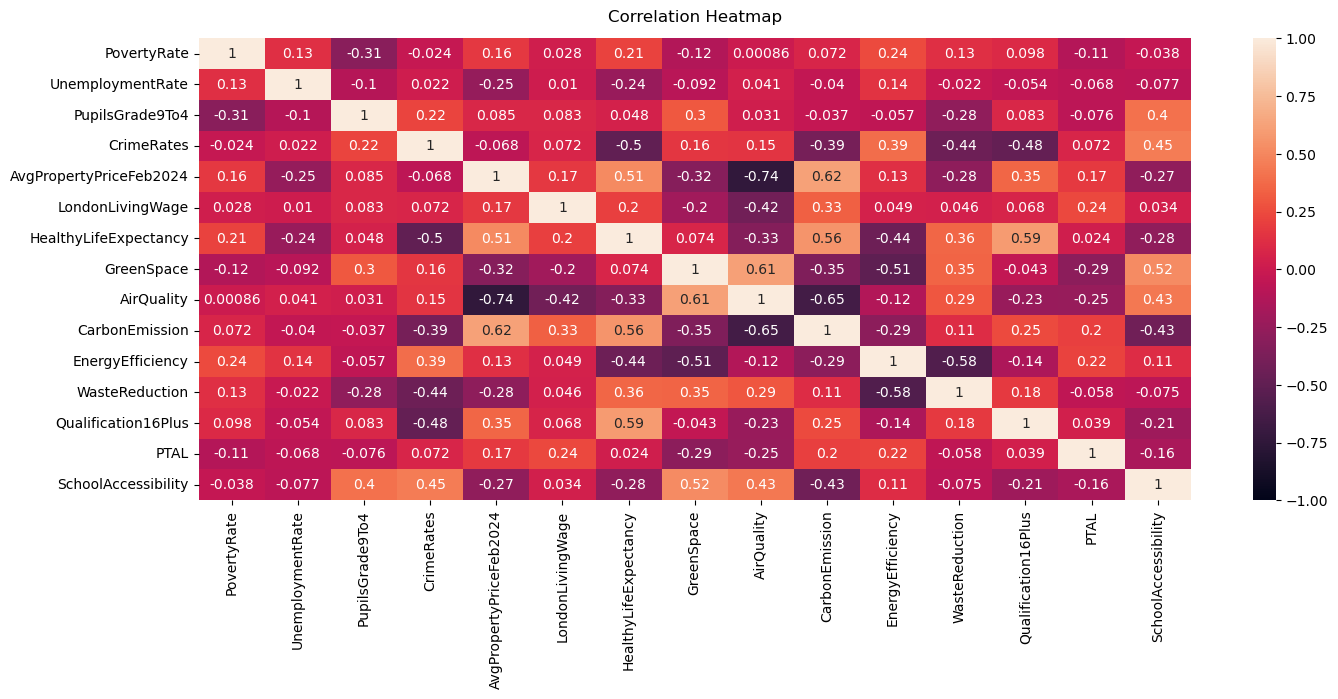

[4 2 5 2 5 0 3 2 2 2 2 4 0 0 5 2 2 2 0 3 1 4 4 5 4 2 1 4 1 4 2 0 3]


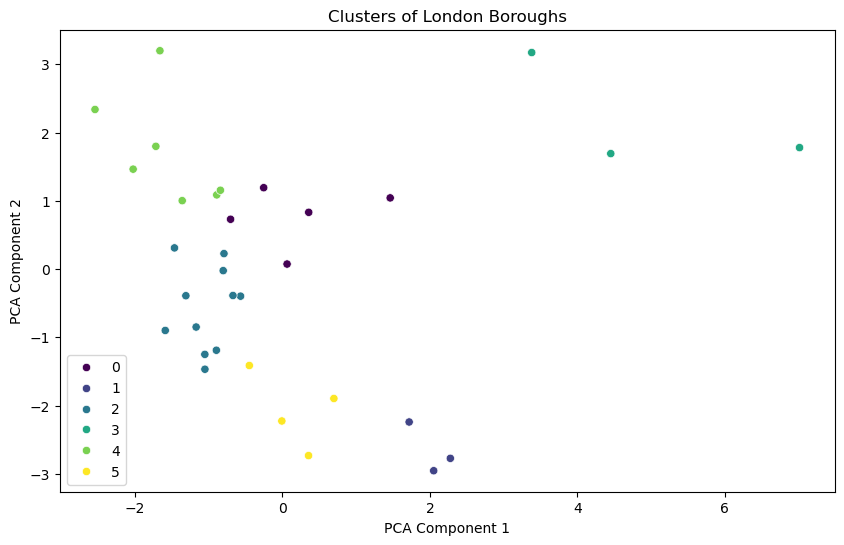

Nearest Cluster for User Preference: 2
Ranked Boroughs based on User Preference:
              Area  Distance
30  Waltham Forest  0.141506
8           Ealing  0.238535
3            Brent  0.416330
7          Croydon  0.509256
9          Enfield  0.550586
17        Hounslow  0.666038
16      Hillingdon  0.755603
15        Havering  0.847990
25       Redbridge  0.910984
10       Greenwich  0.999546
1           Barnet  1.057795


In [389]:
# Main execution
filepath = "C:/Users/Jamie/python_ws/Area_Recommender/data/London_borough.csv"
df = load_and_clean_data(filepath)
user_preference = generate_user_preference(df)
imputed_df = impute_missing_data(df)
visualize_data(imputed_df)
scaler, pca, pca_df = standardize_and_reduce_data(imputed_df)
kmeans, clusters = perform_clustering(pca_df)

# Visualization of clusters
df['Cluster'] = clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], hue=clusters, palette="viridis", legend="full")
plt.title('Clusters of London Boroughs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


imputed_df['Area'] = df['Area']
ranked_boroughs = ranked_borough(imputed_df, clusters, user_preference, scaler, pca, kmeans)


In [390]:
# Streamlit UI
st.title("London Borough Recommender")

st.sidebar.header("User Preferences")

user_preferences = {}
for col in df.columns:
    if col != 'Area':
        user_preferences[col] = st.sidebar.number_input(f"{col}:", value=float(df[col].mean()))

if st.sidebar.button("Submit"):
    user_preference = np.array([[user_preferences[col] for col in user_preferences]])
    ranked_boroughs = ranked_borough(imputed_df, clusters, user_preference, scaler, pca, kmeans)
    st.write("Recommended Boroughs:", ranked_boroughs)
else:
    st.write("Please enter your preferences and click Submit.")